In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import h5py

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

import statsmodels.api as sm

from statannotations.Annotator import Annotator
import pyBigWig

In [2]:
# relevant track indices for tissues with matches DNase and CAGE tracks
DNASE = {"Pancreas": 257,
                 "Ovary": 439,
                 "Liver": 452,
                 "Uterus": 283,
                 "Testis": 665,
                 "Spleen": 594,
                 "Lung": 245,
                 "Thyroid": 241,
                 "Prostate": 653,
                 "Vagina": 382,
                 "Stomach": 204,
                 "Adrenal_Gland": 265,
                 "Cells_EBV-transformed_lymphocytes": 69}


CAGE = {"Pancreas": 4946,
              "Ovary": 4688,
              "Liver": 4686,
              "Uterus": 4910,
              "Testis": 4694,
              "Spleen": 4693,
              "Lung": 4687,
              "Thyroid": 4696,
              "Prostate": 4690,
              "Vagina": 5175,
              "Stomach": 4959,
              "Adrenal_Gland": 4977,
              "Cells_EBV-transformed_lymphocytes": 5110}

In [3]:
# human readable descriptions of the matched tracks
track_to_desc = {}

data = pd.read_table("human_targets.txt", sep='\t')
print(data.columns)

for i in set().union(CAGE.values(), DNASE.values()):
    desc = data.loc[data['index'] == i].get('description')
    track_to_desc[i] = desc.values[0]

Index(['index', 'genome', 'identifier', 'file', 'clip', 'scale', 'sum_stat',
       'description'],
      dtype='object')


In [4]:
track_to_desc

{257: 'DNASE:pancreas male adult (34 years)',
 265: 'DNASE:adrenal gland male adult (37 years)',
 653: 'DNASE:prostate gland male adult (37 years)',
 665: 'DNASE:testis male adult (54 years)',
 283: 'DNASE:uterus female adult (53 years)',
 4910: 'CAGE:uterus, adult, pool1',
 439: 'DNASE:ovary female adult (53 years)',
 5175: 'CAGE:vagina, adult',
 452: 'DNASE:liver female embryo (101 day) and female embryo (113 days)',
 69: 'DNASE:GM12878',
 204: 'DNASE:stomach female embryo (107 days)',
 4686: 'CAGE:liver, adult, pool1',
 4687: 'CAGE:lung, adult, pool1',
 4688: 'CAGE:ovary, adult, pool1',
 594: 'DNASE:spleen male adult (54 years)',
 4946: 'CAGE:pancreas, adult,',
 4690: 'CAGE:prostate, adult, pool1',
 4693: 'CAGE:spleen, adult, pool1',
 4694: 'CAGE:testis, adult, pool1',
 4696: 'CAGE:thyroid, adult, pool1',
 4959: 'CAGE:stomach, fetal,',
 4977: 'CAGE:adrenal gland, adult, pool1',
 241: 'DNASE:thyroid gland male adult (37 years)',
 245: 'DNASE:upper lobe of left lung male adult (37 yea

5 basenji2 replicates, 5313 tracks, eQTL set sizes vary by tissue

In [5]:
# template path for where h5 prediction files are stored for each of the 5 replicates
# for example, use as eqtl_preds_path.format(replicate, tissue, variant_set)
eqtl_preds_path = '../enformer/gtex_fine/preds/basenji2_{}_{}_{}_REF_ALT/sad.h5'

# fine-mapped eQTLs stored here as {tissue}.tsv files
susie_results_path = '../enformer/gtex_fine/susie'

# single file containing eQTL variant gene pairs
gtex_genes_file = '../genomes/gtex_genes.bed'

# all eQTLs stored here as {tissue}_{variant_set}.vcf files
vcfs_path = "../enformer/gtex_fine/vcf"

# for calculating phyloP scores
phylop_bigwig_file = "../conservation/241-mammalian-2020v2.bigWig"
phylop_bw = pyBigWig.open(phylop_bigwig_file)

# (relative) location to save output plots
save_path = 'plots'

In [6]:
# set absolute vs. relative SAD score depending on your analysis
relative_score = False

def get_eqtl_sad_preds(path, tissue):
    
    # count number of eQTLs for this tissue:
    num_eqtls = h5py.File(eqtl_preds_path.format(1, tissue, 'pos'), 'r')['SAD'].shape[0]

    pos_preds = np.zeros((5, num_eqtls, 5313))
    neg_preds = np.zeros((5, num_eqtls, 5313))

    for rep in range(5):
        hf_pos_ref = np.array(h5py.File(eqtl_preds_path.format(rep+1, tissue, 'pos'), 'r')['REF_sum'])
        hf_pos_alt = np.array(h5py.File(eqtl_preds_path.format(rep+1, tissue, 'pos'), 'r')['ALT_sum'])
        assert(hf_pos_ref.shape == (num_eqtls, 5313))
        assert(hf_pos_alt.shape == (num_eqtls, 5313))
        
        if relative_score:
            pos_preds[rep, :, :] = (hf_pos_alt - hf_pos_ref)/hf_pos_ref ##relative score
        else:
            pos_preds[rep, :, :] = hf_pos_alt - hf_pos_ref ##absolute score

        hf_neg_ref = np.array(h5py.File(eqtl_preds_path.format(rep+1, tissue, 'neg'), 'r')['REF_sum'])
        hf_neg_alt = np.array(h5py.File(eqtl_preds_path.format(rep+1, tissue, 'neg'), 'r')['ALT_sum'])
        assert(hf_neg_ref.shape == (num_eqtls, 5313))
        assert(hf_neg_alt.shape == (num_eqtls, 5313))
        
        if relative_score:
            neg_preds[rep, :, :] = (hf_neg_alt - hf_neg_ref)/hf_neg_ref ##relative score
        else:
            neg_preds[rep, :, :] = hf_neg_alt - hf_neg_ref ##absolute score
    
    return pos_preds, neg_preds

## Set up dictonaries for tissues, define functions for creating new df columns

In [7]:
# create dict keyed by [tissue][variant_set] to keep track of gtex tissue dfs
df_results_eqtls = {}
num_rows_dfs_pos, num_rows_dfs_neg = {}, {}

# add sign agreement columns for plotting
def frac_agree_label(row):
    label, reps = row['eQTL direction'], row['SAD signs']
    pos_count = sum(1 for i in reps if i > 0)
    if label == True:
        return pos_count / 5
    return (5 - pos_count) / 5

def frac_agree_reps(row):
    reps = row['SAD signs']
    pos_count = sum(1 for i in reps if i > 0)
    return max(pos_count, 5-pos_count) / 5

def add_sign_agreement_columns(df):
    df['fraction sign agreement eQTL direction'] = df.apply(lambda row: frac_agree_label(row), axis=1)
    df['fraction sign agreement among reps'] = df.apply(lambda row: frac_agree_reps(row), axis=1)

    df['num sign agreement eQTL direction'] = (df['fraction sign agreement eQTL direction']*5).astype(int)
    df['num sign agreement among reps'] = (df['fraction sign agreement among reps']*5).astype(int)

    df['(label sign agreement, rep sign agreement)'] = list(zip(df['num sign agreement eQTL direction'],
                                                            df['num sign agreement among reps']))
    df.loc[~df['(label sign agreement, rep sign agreement)'].isin([(0,5), (5,5)]), '(label sign agreement, rep sign agreement)'] = 'noise'
    df['(label sign agreement, rep sign agreement)'] = df['(label sign agreement, rep sign agreement)'].map(str)
    return

def majority_vote_sign(row):
    signs = row["SAD signs"]
    return np.sign(np.sum(signs))

def rep_1_sign(row):
    signs = row["SAD signs"]
    return signs[0]

bin_size = 128
offset = bin_size / 2
def get_bin_for_tss_distance(tss_distance):
    sign = np.sign(tss_distance)
    abs_tss_distance = np.abs(tss_distance)
    bin_shift = sign * ((abs_tss_distance + offset) // bin_size)
    return 448 + bin_shift

## calculate all new stats as additional df columns (df per tissue and variant set)

In [8]:
#set to CAGE or DNASE depending on your analysis
assay = CAGE
assay_name = ("CAGE" if assay == CAGE else "DNase")

variant_sets = ["pos", "neg"]
filter = True
verbose = False

tlist = list(assay.keys())
tlist.sort() #inplace

for tissue in tlist:
    track = assay[tissue]

    pos_preds, neg_preds = get_eqtl_sad_preds(eqtl_preds_path, tissue)

    pos_sad_track = pos_preds[:, :, track]
    neg_sad_track = neg_preds[:, :, track]
    
    # take mean of signed sad scores
    pos_sad_mean_track = np.mean(pos_sad_track, axis=0)
    neg_sad_mean_track = np.mean(neg_sad_track, axis=0)
    if verbose:
        print(f"pos set sad mean shape {pos_sad_mean_track.shape}, neg set sad mean shape {neg_sad_mean_track.shape}")

    # compute/record sign and mag separately
    pos_preds_mag, neg_preds_mag = np.abs(pos_preds), np.abs(neg_preds)
    pos_preds_sign, neg_preds_sign = np.sign(pos_preds), np.sign(neg_preds)

    # get signs (signs of sad scores only)
    pos_sad_sign_track = pos_preds_sign[:, :, track]
    neg_sad_sign_track = neg_preds_sign[:, :, track]
    if verbose:
        print(f"pos set sad sign shape {pos_sad_sign_track.shape}, neg set sad sign shape {neg_sad_sign_track.shape}")
        print(pos_sad_sign_track.shape)
        print(pos_sad_sign_track.transpose((1, 0)).shape)
        print(len(pos_sad_sign_track.transpose((1, 0)).tolist()))

    # get mags (mags of sad scores only)
    pos_sad_mag_track = pos_preds_mag[:, :, track]
    neg_sad_mag_track = neg_preds_mag[:, :, track]
    if verbose:
        print(f"pos set sad mag shape {pos_sad_mag_track.shape}, neg set sad mag shape {neg_sad_mag_track.shape}")

    # take mean (magnitude of sad scores only)
    pos_sad_mag_mean_track = np.mean(pos_preds_mag[:, :, track], axis=0)
    neg_sad_mag_mean_track = np.mean(neg_preds_mag[:, :, track], axis=0)
    if verbose:
        print(f"mag only pos set sad mean shape {pos_sad_mag_mean_track.shape}, mag only neg set sad mean shape {neg_sad_mag_mean_track.shape}")
    

    susie_results = pd.read_csv(f"{susie_results_path}/{tissue}.tsv",
                                sep="\t",
                                index_col=0)
    gtex_genes = pd.read_csv(gtex_genes_file,
                            sep="\t", index_col=0)[["name", "chrom", "txStart"]]

    vcfs = {} # a dictonary with 2 dfs for the tissue keyed by [variant_set]
    for variant_set in variant_sets:
        if verbose:
            print(f"filter bools set to {filter}")
        vcfs[variant_set] = pd.read_csv(f"{vcfs_path}/{tissue}_{variant_set}.vcf",
                                        sep="\t",
                                        skiprows=1, 
                                        names=["chr", "pos", "variant", "ref", "alt", ".", "..", "..."])
        if verbose:
            print(f"original shape of the {variant_set} variant set is {vcfs[variant_set].shape}")

        num_rows = vcfs[variant_set].shape[0]

        if variant_set == "pos":
            assert(pos_sad_track.transpose((1, 0)).shape == (num_rows, 5))
            vcfs[variant_set]["SAD scores"] = pos_sad_track.transpose((1, 0)).tolist()
            
            assert(pos_sad_sign_track.transpose((1, 0)).shape == (num_rows, 5))
            vcfs[variant_set]["SAD signs"] = pos_sad_sign_track.transpose((1, 0)).tolist()

            assert(pos_sad_mag_track.transpose((1, 0)).shape == (num_rows, 5))
            vcfs[variant_set]["SAD magnitudes"] = pos_sad_mag_track.transpose((1, 0)).tolist()

            assert(num_rows == len(pos_sad_mean_track.tolist()))
            vcfs[variant_set]["SAD mean"] = pos_sad_mean_track.tolist() 

            assert(num_rows == len(pos_sad_mag_mean_track.tolist()))
            vcfs[variant_set]["SAD mean magnitude"] = pos_sad_mag_mean_track.tolist()

        else:
            assert(neg_sad_track.transpose((1, 0)).shape == (num_rows, 5))
            vcfs[variant_set]["SAD scores"] = neg_sad_track.transpose((1, 0)).tolist()
            
            assert(neg_sad_sign_track.transpose((1, 0)).shape == (num_rows, 5))
            vcfs[variant_set]["SAD signs"] = neg_sad_sign_track.transpose((1, 0)).tolist()

            assert(neg_sad_mag_track.transpose((1, 0)).shape == (num_rows, 5))
            vcfs[variant_set]["SAD magnitudes"] = neg_sad_mag_track.transpose((1, 0)).tolist()

            assert(num_rows == len(neg_sad_mean_track.tolist()))
            vcfs[variant_set]["SAD mean"] = neg_sad_mean_track.tolist()

            assert(num_rows == len(neg_sad_mag_mean_track.tolist()))
            vcfs[variant_set]["SAD mean magnitude"] = neg_sad_mag_mean_track.tolist()

        # merging with the SuSIE finemapping results and GTeX gene info to get metadata like TSS distance and eQTL direction
        vcfs[variant_set] = vcfs[variant_set].merge(susie_results, on="variant")
        vcfs[variant_set] = vcfs[variant_set].merge(gtex_genes, left_on="gene", right_on="name")
        
        # create new columns for eQTL direction, effect size, TSS distance
        vcfs[variant_set]["eQTL direction"] = vcfs[variant_set]["beta_marginal"] > 0
        
        vcfs[variant_set]["eQTL effect size"] = vcfs[variant_set]["beta_marginal"]
        vcfs[variant_set]["eQTL effect size magnitude"] = np.abs(vcfs[variant_set]["beta_marginal"])
        
        vcfs[variant_set]["TSS distance"] = (vcfs[variant_set]["txStart"] - vcfs[variant_set]["pos"])
        vcfs[variant_set]["TSS distance magnitude"] = np.abs(vcfs[variant_set]["TSS distance"])
        
        # add majority vote column for sign
        vcfs[variant_set]["SAD sign majority vote"] = vcfs[variant_set].apply(lambda row: majority_vote_sign(row), axis=1)
        
        # add replicate 1 prediction column for sign
        vcfs[variant_set]["SAD sign replicate 1"] = vcfs[variant_set].apply(lambda row: rep_1_sign(row), axis=1)
        
        # add PhyloP scores
        vcfs[variant_set]["phyloP"] = vcfs[variant_set].apply(lambda x: phylop_bw.stats(x.chr, x.pos-1, x.pos)[0], axis=1)
        
        if verbose:
            print(f"after merging with susie results and gtex gene metadata, shape is {vcfs[variant_set].shape}")

        if filter:
            if verbose:
                print(f"filtering on the {variant_set} variant set...")

            # replicating the filtering described in the Enformer methods
            # only keeping variants where the eQTL direction was the same across all genes 
            variant_mask = vcfs[variant_set].groupby('variant')["eQTL direction"].unique().apply(lambda x: len(x))
            variant_mask = variant_mask[variant_mask == 1].index.values
            vcfs[tissue] = vcfs[variant_set][vcfs[variant_set]["variant"].isin(variant_mask)]
            if verbose:
                print(f"after filtering to eQTLS where direction agrees for all genes, shape is {vcfs[variant_set].shape}")

            if variant_set == "pos":
            # filter to only eqtls with pip > 0.9
                vcfs[variant_set] = vcfs[tissue][vcfs[tissue]["pip"] > 0.9]
            else:
                vcfs[variant_set] = vcfs[tissue][vcfs[tissue]["pip"] < 0.01]
            if verbose:
                print(f"after filtering by PIP score, shape is {vcfs[variant_set].shape}")

            # retain closest gene per variant
            vcfs[variant_set] = vcfs[variant_set].loc[vcfs[variant_set].groupby('variant')["TSS distance"].idxmin()]
            if verbose:
                print(f"after filtering to closest gene per variant, shape is {vcfs[variant_set].shape}")
            
            # only keep eQTLs within Basenji receptive field
            vcfs[variant_set] = vcfs[variant_set][vcfs[variant_set]["TSS distance"].abs() < (896/2 - 1)*128]
            if verbose:
                print(f"after filtering to eQTLS within Basenji receptive field, shape is {vcfs[variant_set].shape}")

        # assign eQTLs to TSS distance bins
        vcfs[variant_set]["TSS bin"] = vcfs[variant_set]["TSS distance"].apply(lambda x: get_bin_for_tss_distance(x))
        if verbose:
            print(f"final shape is {vcfs[variant_set].shape} \n")
        
        if variant_set == "pos":
            # if positive eqtl set, add the sign agreement columns
            add_sign_agreement_columns(vcfs[variant_set])
    
    # record the number of rows of the dfs for this variant set
    num_rows_dfs_pos[tissue] = vcfs["pos"].shape[0]
    num_rows_dfs_neg[tissue] = vcfs["neg"].shape[0]
            
    # record this the vcfs dictonary (with pos and neg sets) in the tissue dictonary
    df_results_eqtls[tissue] = vcfs
    

In [9]:
# create tlist_sorted_pos, which is sorted by highest number of eqtls to lowest for the positive set

tdict_sorted_pos = {k: v for k, v in sorted(num_rows_dfs_pos.items(), key=lambda item: item[1], reverse=True)}
tlist_sorted_pos = tdict_sorted_pos.keys()

## construct combined pos and neg set dfs that combine the tissue eQTL data

In [10]:
all_tissue_df_list = []

for tissue in tlist_sorted_pos:
    df = df_results_eqtls[tissue]["pos"]
    num_rows = df.shape[0]
        
    # additional columns for tissue and tracks
    df["tissue"] = tissue
    df["DNase track"] = DNASE[tissue]
    df["CAGE track"] = CAGE[tissue]
    all_tissue_df_list.append(df)

In [11]:
all_tissue_df = pd.concat(all_tissue_df_list)
    
# create additional renamed columns for prettier plotting
all_tissue_df["sign agreement"] = all_tissue_df["(label sign agreement, rep sign agreement)"]
all_tissue_df.loc[all_tissue_df["sign agreement"]=="(5, 5)", "sign agreement"] = "Consistently correct"
all_tissue_df.loc[all_tissue_df["sign agreement"]=="noise", "sign agreement"] = "Inconsistent"
all_tissue_df.loc[all_tissue_df["sign agreement"]=="(0, 5)", "sign agreement"] = "Consistently incorrect"

In [12]:
print(all_tissue_df.shape[0])

# assert that the number of rows is equal to the sum of rows of the individual tissue dfs
summed_rows = np.sum([df.shape[0] for df in all_tissue_df_list])
assert(all_tissue_df.shape[0] == summed_rows)

8446


## replicate correlation boxplots for comparing positive and negative sets

In [13]:
corr_df = pd.DataFrame([])

for _, tissue in enumerate(tlist_sorted_pos):
    pos_rep_preds = df_results_eqtls[tissue]['pos']['SAD scores'].tolist()
    ref_preds = np.vstack(pos_rep_preds).astype(np.float32).transpose()
    pairwise_corrs = np.corrcoef(ref_preds)[np.triu_indices(5, k=1)]
    for i, c in enumerate(pairwise_corrs):
        corr_df = corr_df.append({"Tissue": tissue,
                                  "Variant set": "Positive set (PIP > 0.9)",
                                  "Assay": assay_name,
                                  "Statistic": "SAD",
                                  "Model pair": i,
                                  "SpearmanR between replicates": c}, ignore_index=True)
    
    neg_rep_preds = df_results_eqtls[tissue]['neg']['SAD scores'].tolist()
    ref_preds = np.vstack(neg_rep_preds).astype(np.float32).transpose()
    pairwise_corrs = np.corrcoef(ref_preds)[np.triu_indices(5, k=1)]
    for i, c in enumerate(pairwise_corrs):
        corr_df = corr_df.append({"Tissue": tissue,
                                  "Variant set": "Negative set (PIP < 0.01)",
                                  "Assay": assay_name,
                                  "Statistic": "SAD",
                                  "Model pair": i,
                                  "SpearmanR between replicates": c}, ignore_index=True)

# tissue names format
corr_df.loc[corr_df["Tissue"] == "Cells_EBV-transformed_lymphocytes", "Tissue"] = "Cells (EBV-transformed\nlymphocytes)"
corr_df.loc[corr_df["Tissue"] == "Adrenal_Gland", "Tissue"] = "Adrenal Gland"

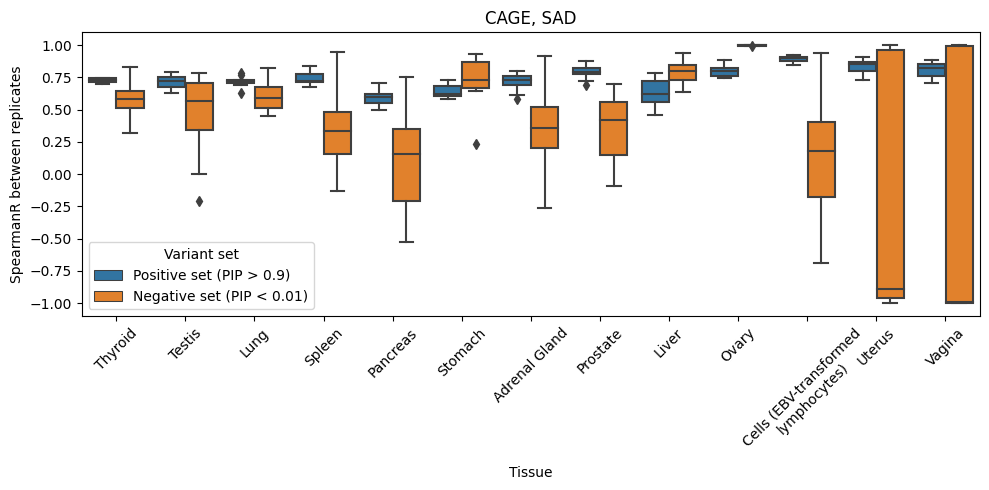

In [14]:
# tissue labels format
labels = list(tlist_sorted_pos).copy()
labels[6] = "Adrenal Gland"
labels[10] = "Cells (EBV-transformed\nlymphocytes)"


for stat in ["SAD"]:
    df_subs = corr_df[(corr_df["Statistic"] == stat) & (corr_df["Assay"] == assay_name)]
    fig, ax = plt.subplots(figsize=(10,5))
    ax = sns.boxplot(data=df_subs,
                     x="Tissue",
                     hue="Variant set",
                     order=labels,
                     y="SpearmanR between replicates",
                     ax=ax)
    ax.set_title(f"{assay_name}, {stat}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(
        f"{save_path}/{assay_name}_{stat}_pairwise_correlations.pdf", dpi=300)

## sign agreement analysis - between models and versus the eQTL label (sign of recorded effect size)

In [15]:
tissue_heatmaps_sign = {}
tissue_frac_true_positive = {}
tissue_heatmaps_sign_pct = {}

In [16]:
for tissue in tlist_sorted_pos:
    df = df_results_eqtls[tissue]['pos']
    num_rows = df.shape[0]
    
    # create heatmap data
    sign_heatmap_counts = np.zeros((6,6))
    total_sign_counts = np.zeros((6,6))
    pos_sign_counts = np.zeros((6,6))

    for i in df.index.values:
        label_i = df._get_value(i,'num sign agreement eQTL direction')
        reps_i = df._get_value(i,'num sign agreement among reps')
        sign_i = df._get_value(i,'eQTL direction')
        sign_heatmap_counts[reps_i, label_i] += 1
        total_sign_counts[reps_i, label_i] += 1
        if sign_i:
            pos_sign_counts[reps_i, label_i] += 1

    print(sign_heatmap_counts)
    assert(sign_heatmap_counts.sum() == num_rows)

    frac_true_positive = pos_sign_counts / total_sign_counts

    # chop off upper heatmap (empty) rows
    sign_heatmap_counts = sign_heatmap_counts[3:, :]
    frac_true_positive = frac_true_positive[3:, :]
    
    # create percentage heatmap data
    sign_heatmap_pcts = sign_heatmap_counts / num_rows
    assert(sign_heatmap_pcts.sum().round() == 1)

    # save heatmap counts and heatmap percentages to dicts
    tissue_heatmaps_sign[tissue] = sign_heatmap_counts
    tissue_frac_true_positive[tissue] = frac_true_positive
    tissue_heatmaps_sign_pct[tissue] = sign_heatmap_pcts
    

[[  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0. 217. 256.   0.   0.]
 [  0. 264.   0.   0. 282.   0.]
 [354.   0.   0.   0.   0. 453.]]
[[  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0. 178. 200.   0.   0.]
 [  0. 189.   0.   0. 212.   0.]
 [348.   0.   0.   0.   0. 399.]]
[[  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0. 165. 166.   0.   0.]
 [  0. 189.   0.   0. 178.   0.]
 [219.   0.   0.   0.   0. 290.]]
[[  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.  97. 100.   0.   0.]
 [  0. 103.   0.   0.  91.   0.]
 [134.   0.   0.   0.   0. 214.]]
[[  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0. 109. 104.   0.   0.]
 [  0. 107.   0.   0. 116.   0.]
 [123.   0.   0.   0.   0. 160.]]
[[  0

/clusterfs/nilah/ayesha/envs/plotting_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


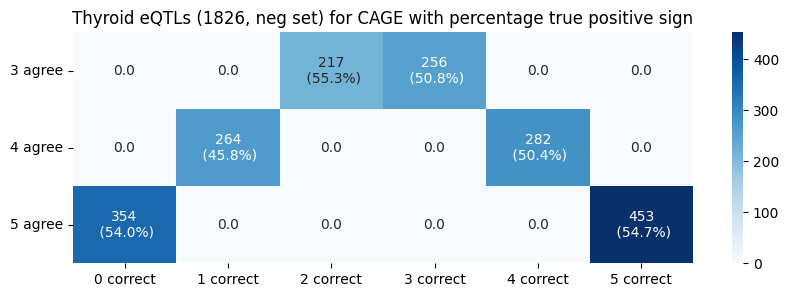

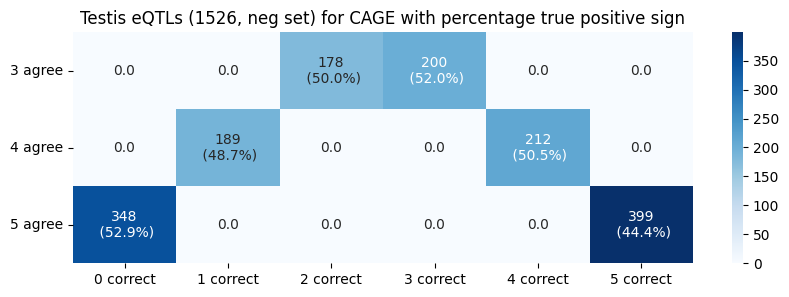

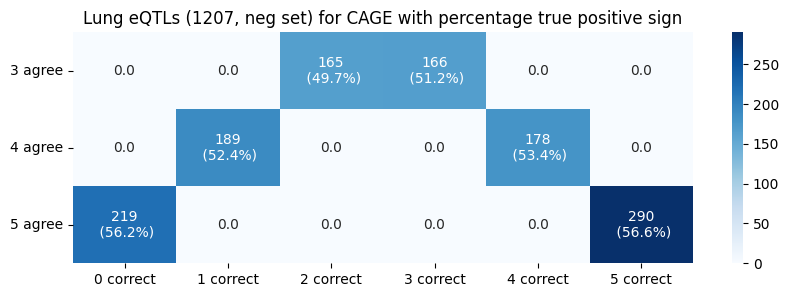

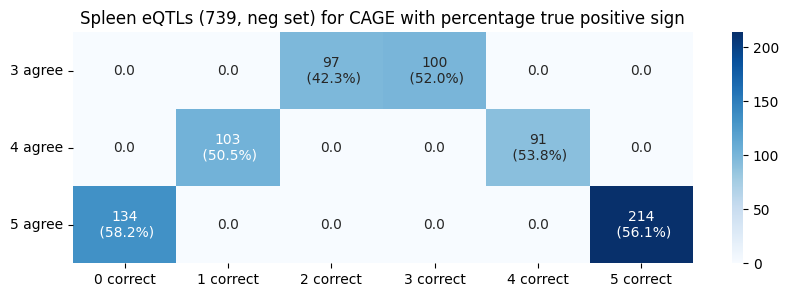

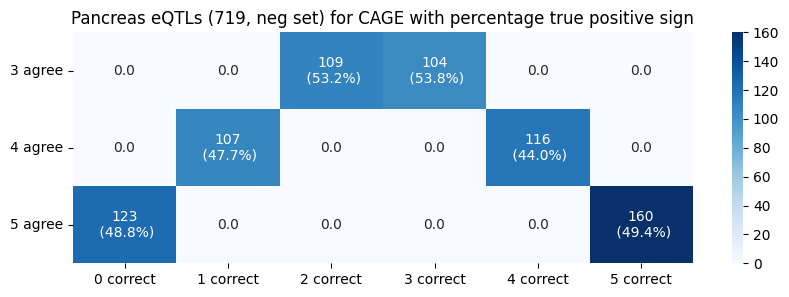

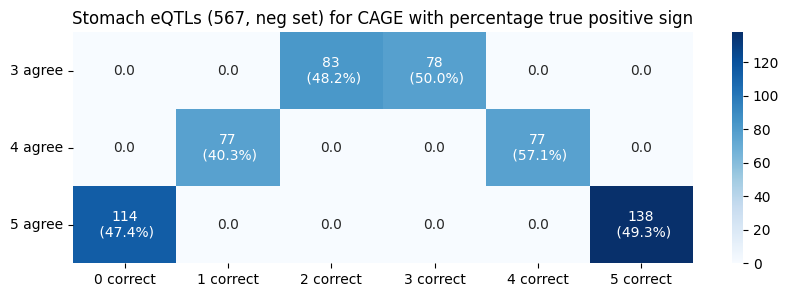

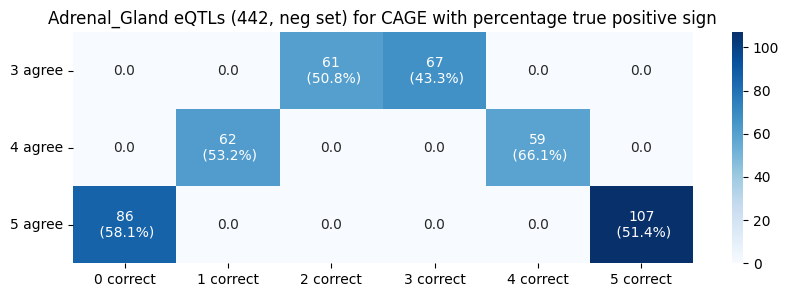

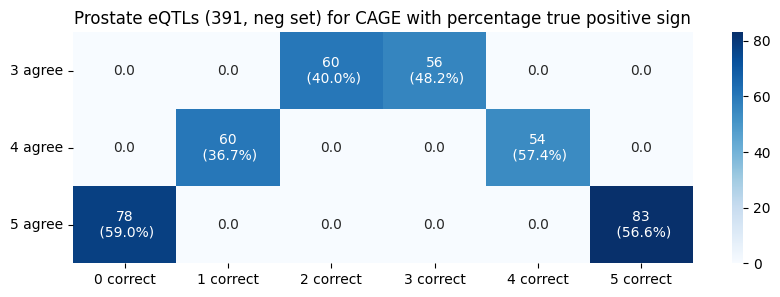

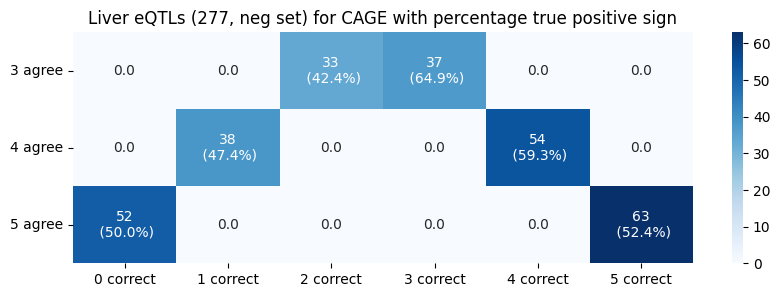

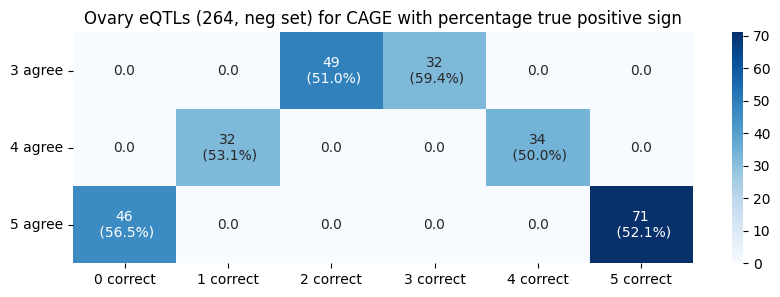

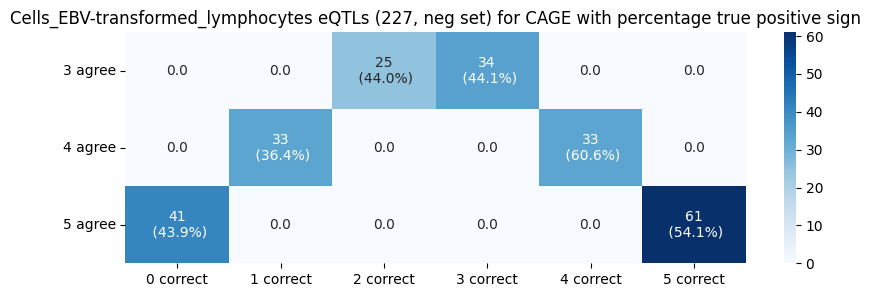

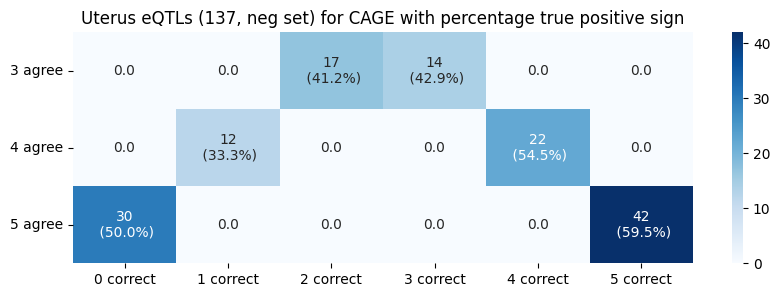

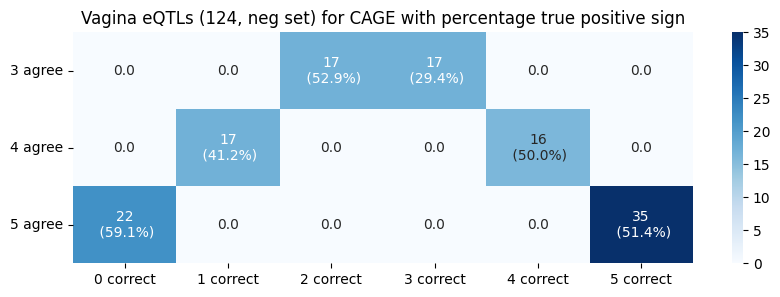

In [17]:
# sign heatmaps
for tissue in tlist_sorted_pos:
    sign_heatmap_counts = tissue_heatmaps_sign[tissue]
    df = df_results_eqtls[tissue]['pos']
    num_rows = df.shape[0]

    plt.figure(figsize=(10,3))

    labels = sign_heatmap_counts.tolist()
    for i in range(len(sign_heatmap_counts)):
        for j in range(len(sign_heatmap_counts[0])):
            if labels[i][j] != 0:
                pct = round(tissue_frac_true_positive[tissue][i,j]*100, 1)
                labels[i][j] = f"{int(sign_heatmap_counts[i,j])}\n ({pct}%)"

    sign_heatmap_df = pd.DataFrame(data = sign_heatmap_counts,
                                   index = ["3 agree", "4 agree", "5 agree"],
                                   columns = [f"{i} correct" for i in range(6)])
                
    sns.heatmap(sign_heatmap_df, annot=np.array(labels), fmt='', cmap='Blues')
    plt.ylim(3, 0)
    plt.yticks(rotation=0)
    plt.title(f"{tissue} eQTLs ({num_rows}, {variant_set} set) for {assay_name} with percentage true positive sign")

    plt.savefig(f'{save_path}/{assay_name}/{tissue}_{num_rows}_heatmap_counts.pdf')

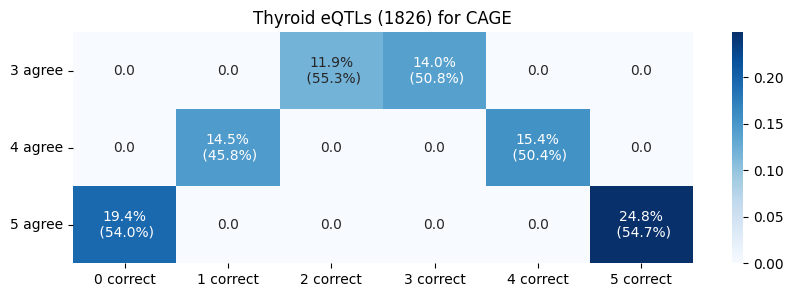

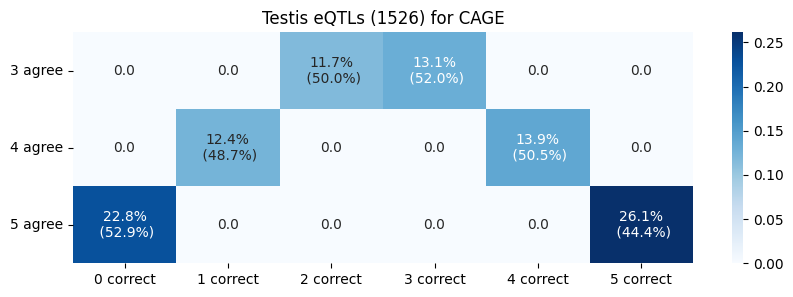

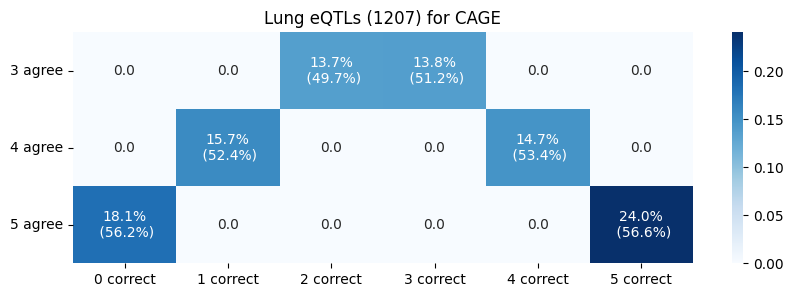

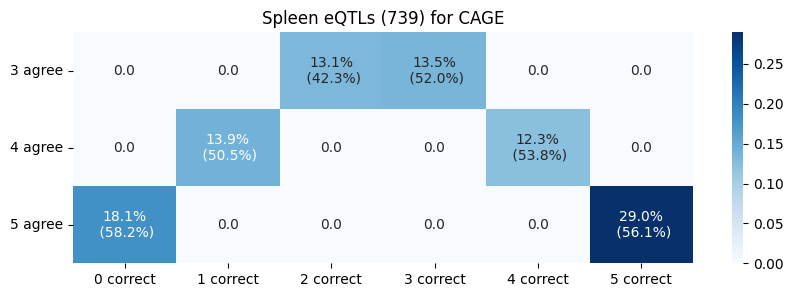

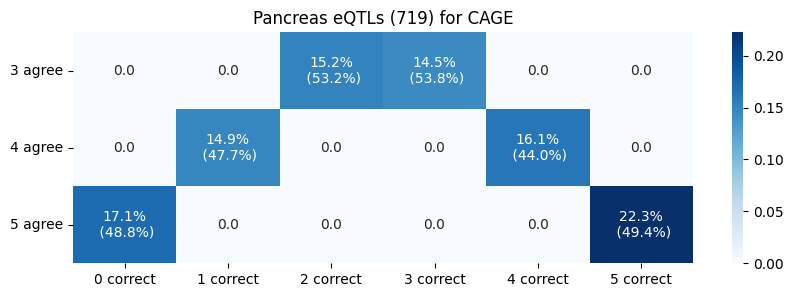

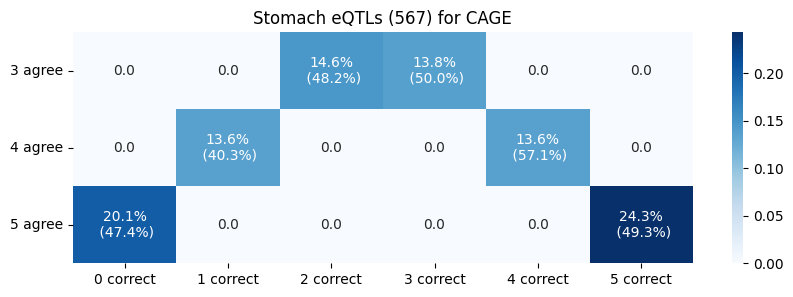

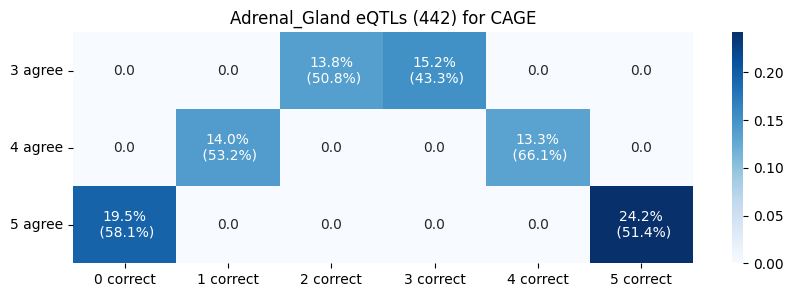

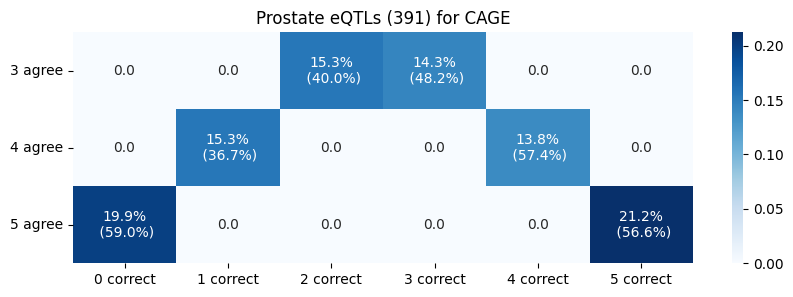

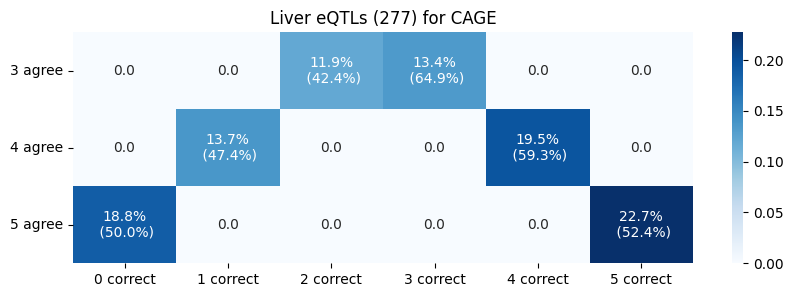

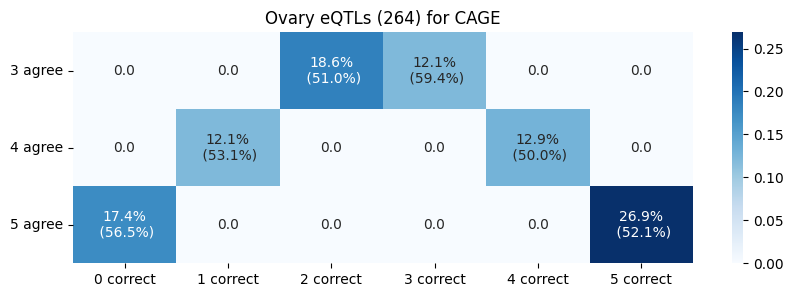

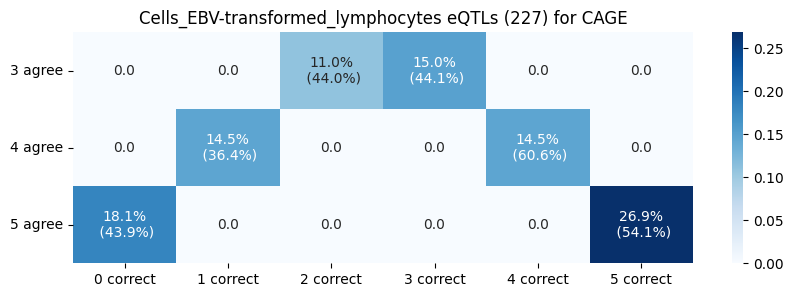

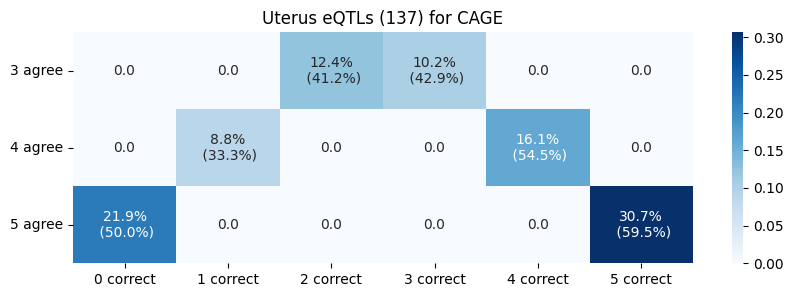

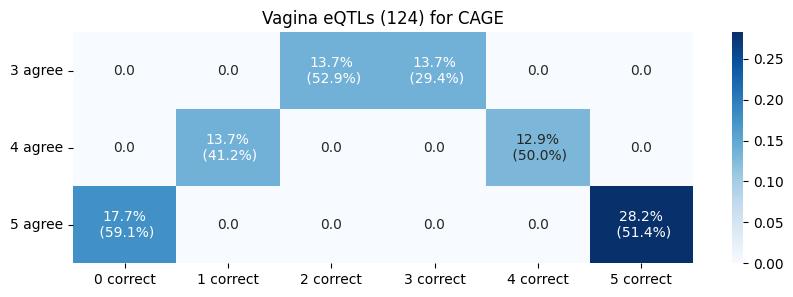

In [18]:
# percentage heatmaps
for tissue in tlist_sorted_pos:
    sign_heatmap_pcts = tissue_heatmaps_sign_pct[tissue]
    df = df_results_eqtls[tissue]['pos']
    num_rows = df.shape[0]

    plt.figure(figsize=(10,3))

    labels = sign_heatmap_pcts.tolist()
    for i in range(len(sign_heatmap_pcts)):
        for j in range(len(sign_heatmap_pcts[0])):
            if labels[i][j] != 0:
                pct = round(tissue_frac_true_positive[tissue][i,j]*100, 1)
                labels[i][j] = f"{round(sign_heatmap_pcts[i,j]*100, 1)}%\n ({pct}%)"

    sign_heatmap_df_pcts = pd.DataFrame(data = sign_heatmap_pcts,
                              index = ["3 agree", "4 agree", "5 agree"],
                              columns = [f"{i} correct" for i in range(6)])

    sns.heatmap(sign_heatmap_df_pcts, annot=np.array(labels), fmt="", cmap='Blues')
    plt.ylim(3, 0)
    plt.yticks(rotation=0)
    plt.title(f"{tissue} eQTLs ({num_rows}) for {assay_name}")
    #plt.title(f"{tissue} eQTLs ({num_rows}, {variant_set} set) for {assay_name} with percentage true positive sign")

    plt.savefig(f'{save_path}/{assay_name}/{tissue}_{num_rows}_heatmap_percentage.pdf')

## create combined bar plot to represent the heatmap data across all tissues

In [19]:
group_labels = tlist_sorted_pos
con_incorr, con_corr, noise = [], [], []
noise3, noise4 = [], []
true_pos = []

for tissue in tlist_sorted_pos:
    sign_heatmap_pcts = tissue_heatmaps_sign_pct[tissue]
    frac_true_positive = tissue_frac_true_positive[tissue]
    sign_heatmap_counts = tissue_heatmaps_sign[tissue]

    con_incorr.append(sign_heatmap_pcts[2,0]) #bottom left
    con_corr.append(sign_heatmap_pcts[2,5]) #bottom right
    noise4.append(sign_heatmap_pcts[1,1]+sign_heatmap_pcts[1,4])
    noise3.append(sign_heatmap_pcts[0,2]+sign_heatmap_pcts[0,3])
    noise.append(1-(sign_heatmap_pcts[2,0] + sign_heatmap_pcts[2,5]))
    true_pos.append(np.nansum(np.multiply(frac_true_positive, sign_heatmap_counts))/np.sum(sign_heatmap_counts))
    
# sanity checks
for i in range(len(tlist_sorted_pos)):
    assert(con_corr[i]+con_incorr[i]+noise[i] == 1)
    assert((con_corr[i]+con_incorr[i]+noise3[i]+noise4[i]).round() == 1)
    
print('\n\n')    
print(con_corr)
print(con_incorr)
print(noise)

print('\n\n')    
print(noise3)
print(noise4)

for i in range(len(tlist)):
    print(noise[i])
    print(noise3[i]+noise4[i])
    print('\n') 
    
print(true_pos)




[0.24808324205914567, 0.26146788990825687, 0.24026512013256007, 0.2895805142083897, 0.22253129346314326, 0.24338624338624337, 0.2420814479638009, 0.21227621483375958, 0.22743682310469315, 0.2689393939393939, 0.2687224669603524, 0.30656934306569344, 0.28225806451612906]
[0.19386637458926614, 0.22804718217562253, 0.18144159072079535, 0.18132611637347767, 0.17107093184979139, 0.20105820105820105, 0.19457013574660634, 0.19948849104859334, 0.18772563176895307, 0.17424242424242425, 0.18061674008810572, 0.21897810218978103, 0.1774193548387097]
[0.5580503833515882, 0.5104849279161205, 0.5782932891466446, 0.5290933694181326, 0.6063977746870653, 0.5555555555555556, 0.5633484162895928, 0.5882352941176471, 0.5848375451263538, 0.5568181818181819, 0.5506607929515419, 0.4744525547445255, 0.5403225806451613]



[0.25903614457831325, 0.24770642201834864, 0.2742336371168186, 0.2665764546684709, 0.29624478442280944, 0.2839506172839506, 0.28959276018099545, 0.2966751918158568, 0.25270758122743686, 0.30

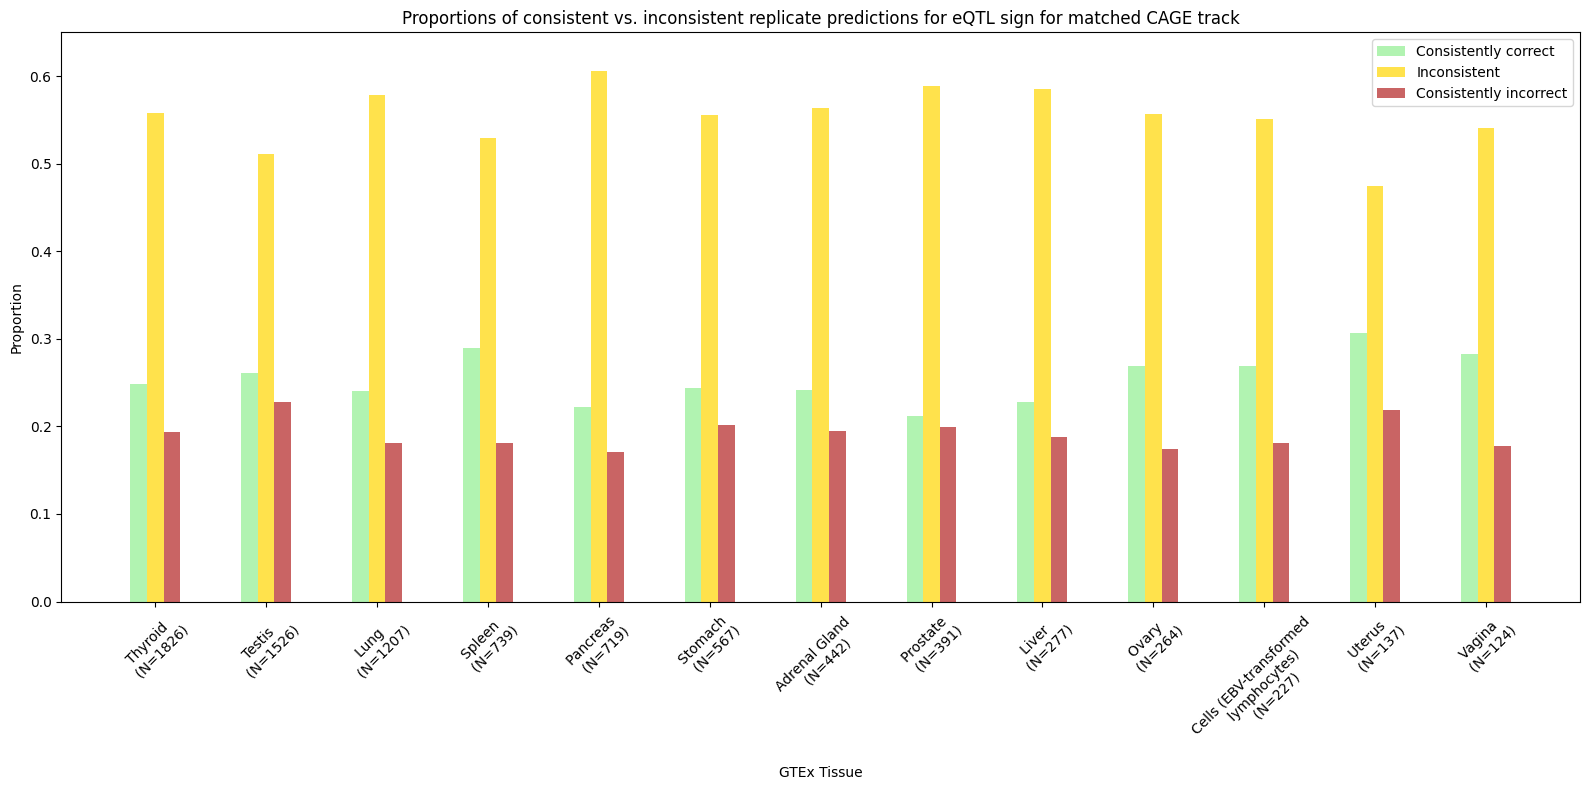

In [20]:
## Not separating 3 vs. 4 rep agreement
## Note: bug fixed, now seeing higher consistently correct fraction as expected

# Define the width of each bar group and the width of each bar within a group
bar_width = 0.15
index = np.arange(len(tlist_sorted_pos))

# edit tissue names format
labels = list(tlist_sorted_pos).copy()
labels[6] = "Adrenal Gland"
labels[10] = "Cells (EBV-transformed \n lymphocytes)"
for i, tissue in enumerate(tlist_sorted_pos):
    labels[i] = f"{labels[i]} \n (N={num_rows_dfs_pos[tissue]})"

fig, ax = plt.subplots(figsize=(16,8))

bar1 = ax.bar(index - bar_width, con_corr, bar_width, label='Consistently correct', color='lightgreen', alpha=0.7)
bar2 = ax.bar(index, noise, bar_width, label='Inconsistent', color='gold', alpha=0.7)
bar3 = ax.bar(index + bar_width, con_incorr, bar_width, label='Consistently incorrect', color='firebrick', alpha=0.7)

ax.set_xlabel('GTEx Tissue')
ax.set_ylabel('Proportion')
ax.set_title(f'Proportions of consistent vs. inconsistent replicate predictions for eQTL sign for matched {assay_name} track')
ax.set_xticks(index)
ax.set_xticklabels(labels, rotation = 45)
ax.legend(loc='upper right')

plt.ylim((0,0.65))
plt.tight_layout()
plt.savefig(f'{save_path}/{assay_name}/aggreate_{assay_name}_noisy_proportion_eqtls_sign.pdf')

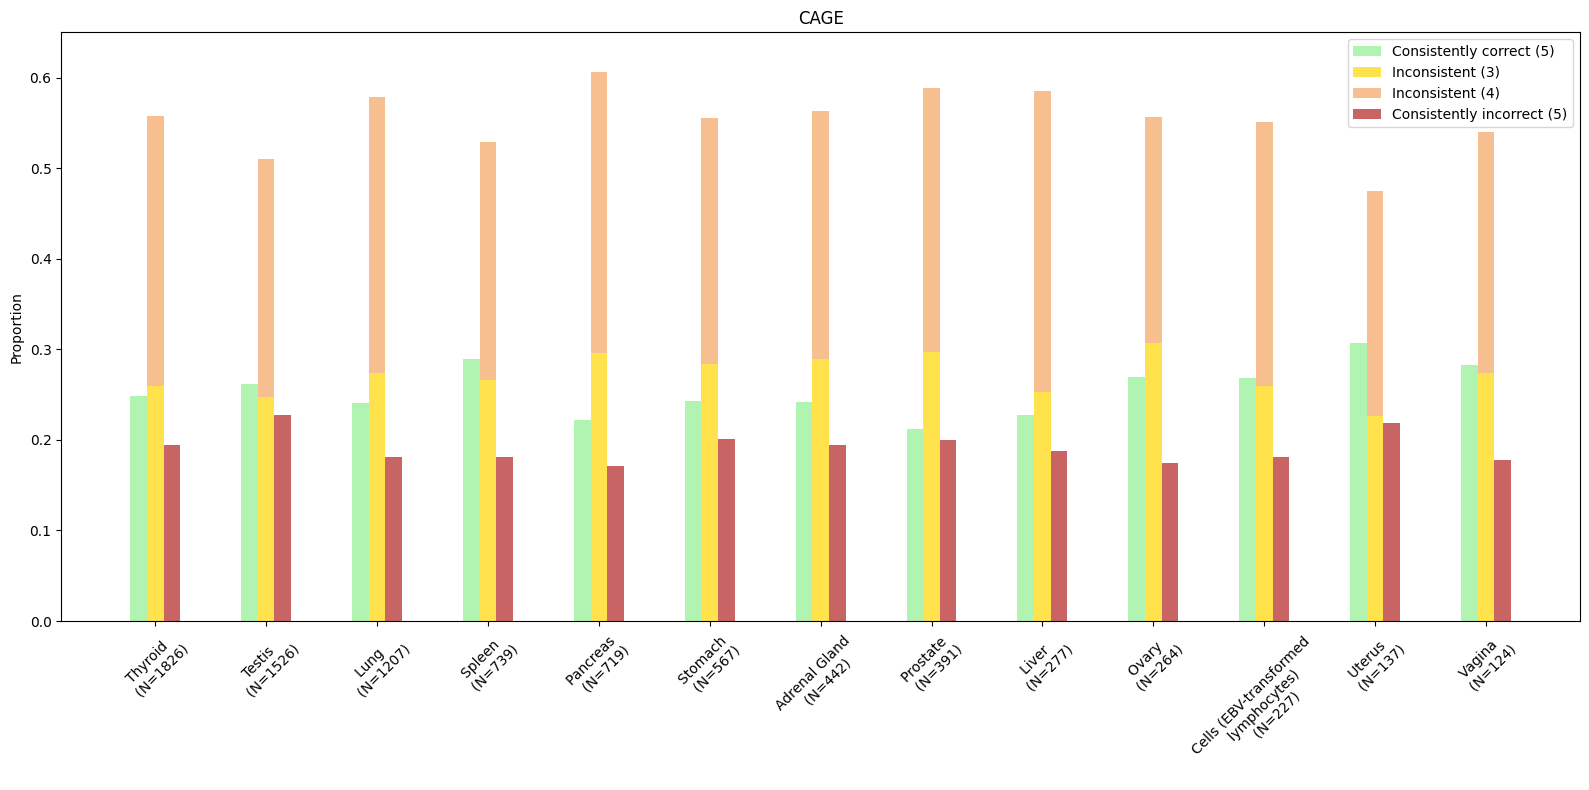

In [21]:
## With separating 3 vs. 4 rep agreement
## Note: bug fixed, now seeing higher consistently correct fraction as expected

# Define the width of each bar group and the width of each bar within a group
bar_width = 0.15
index = np.arange(len(tlist_sorted_pos))

# edit tissue names format
labels = list(tlist_sorted_pos).copy()
labels[6] = "Adrenal Gland"
labels[10] = "Cells (EBV-transformed \n lymphocytes)"
for i, tissue in enumerate(tlist_sorted_pos):
    labels[i] = f"{labels[i]} \n (N={num_rows_dfs_pos[tissue]})"

fig, ax = plt.subplots(figsize=(16,8))

bar1 = ax.bar(index - bar_width, con_corr, bar_width, label='Consistently correct (5)', color='lightgreen', alpha=0.7)
bar2 = ax.bar(index, noise3, bar_width, label='Inconsistent (3)', color='gold', alpha=0.7)
bar22 = ax.bar(index, noise4, bar_width, bottom=noise3, label='Inconsistent (4)', color='sandybrown', alpha=0.7)
bar3 = ax.bar(index + bar_width, con_incorr, bar_width, label='Consistently incorrect (5)', color='firebrick', alpha=0.7)

#ax.set_xlabel('GTEx Tissue')
ax.set_ylabel('Proportion')
#ax.set_title(f'Proportions of consistent vs. inconsistent replicate predictions for eQTL sign for matched {assay_name} track')
ax.set_title(f'{assay_name}')
ax.set_xticks(index)
ax.set_xticklabels(labels, rotation = 45)
ax.legend(loc='upper right')

plt.ylim((0,0.65))
plt.tight_layout()
plt.savefig(f'{save_path}/{assay_name}/aggreate_{assay_name}_stacked_noisy_proportion_eqtls_sign.pdf')

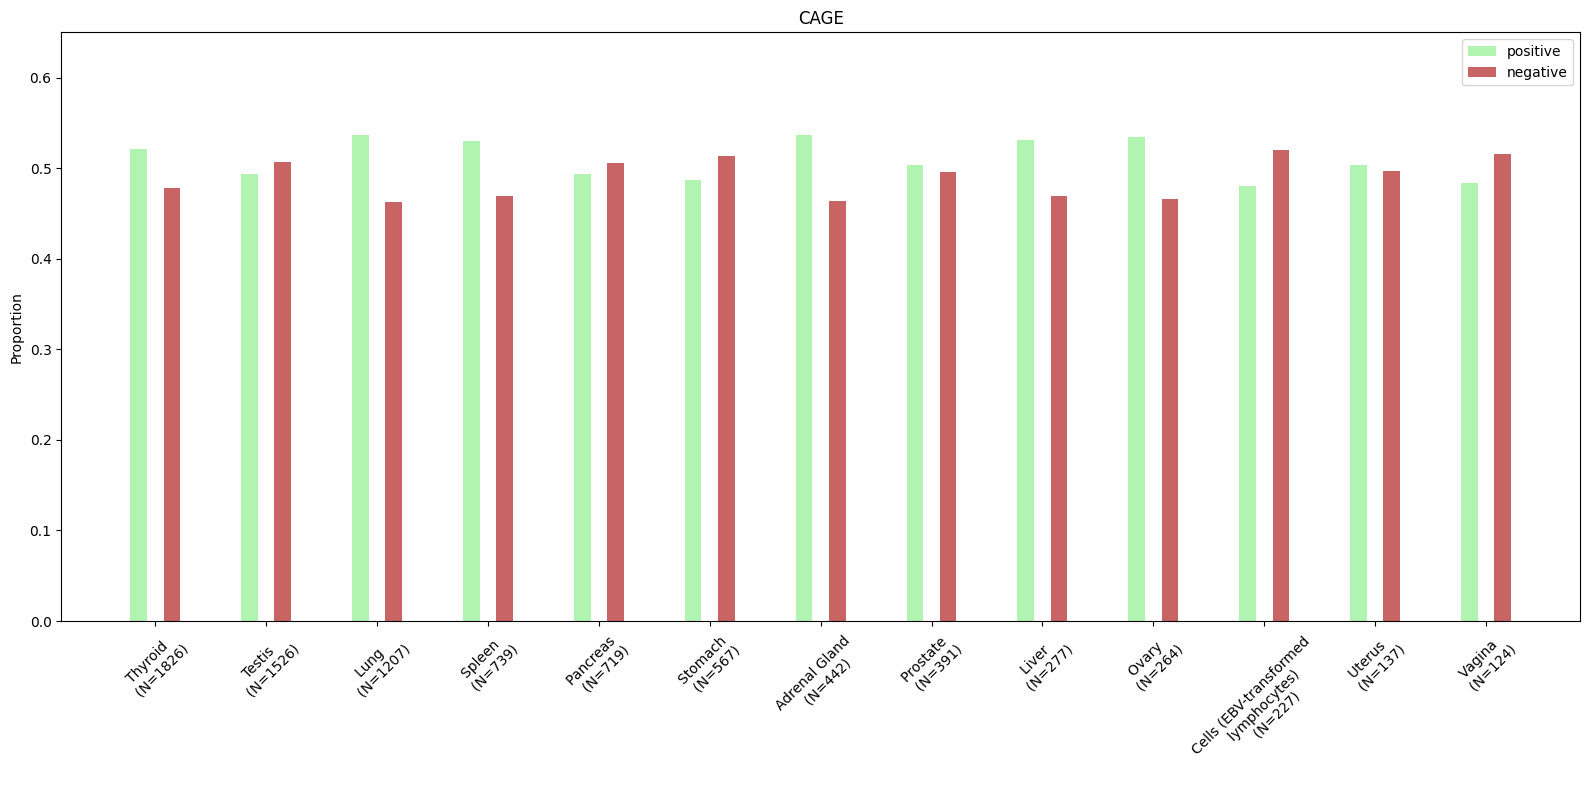

In [22]:
## bar plot of pos/neg sign to check for label imbalance

# Define the width of each bar group and the width of each bar within a group
bar_width = 0.15
index = np.arange(len(tlist_sorted_pos))

fig, ax = plt.subplots(figsize=(16,8))

bar_pos = ax.bar(index - bar_width, true_pos, bar_width, label='positive', color='lightgreen', alpha=0.7)
bar_neg = ax.bar(index + bar_width, [1-pos for pos in true_pos], bar_width, label='negative', color='firebrick', alpha=0.7)

ax.set_ylabel('Proportion')
ax.set_title(f'{assay_name}')
ax.set_xticks(index)
ax.set_xticklabels(labels, rotation = 45)
ax.legend(loc='upper right')

plt.ylim((0,0.65))
plt.tight_layout()
plt.savefig(f'{save_path}/{assay_name}/aggreate_{assay_name}_true_positive_frac_eqtls_sign.pdf')

## Consistency vs. other attributes, boxplots with significance

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Consistently correct vs. Inconsistent: Mann-Whitney-Wilcoxon test two-sided, P_val:2.838e-01 U_stat=4.874e+06
Inconsistent vs. Consistently incorrect: Mann-Whitney-Wilcoxon test two-sided, P_val:6.999e-05 U_stat=3.603e+06
Consistently correct vs. Consistently incorrect: Mann-Whitney-Wilcoxon test two-sided, P_val:2.238e-05 U_stat=1.602e+06
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Consistently correct vs. Inconsistent: Mann-Whitney-Wilcoxon test two-sided, P_val:1.921e-07 U_stat=5.345e+06
Inconsistent vs. Consistently incorrect: Mann-Whitney-Wilcoxon test two-sided, P_val:3.284e-01 U_stat=3.919e+06
Consistently correct vs. Consistently incorrect: Mann-Whitney-Wilcoxon tes

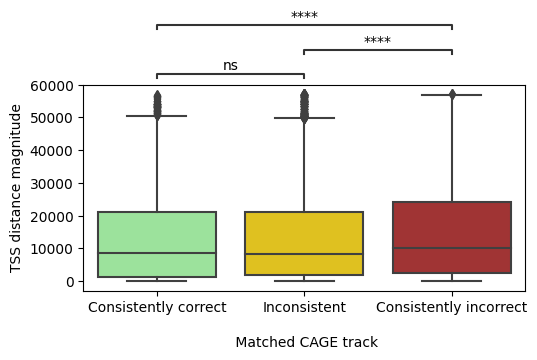

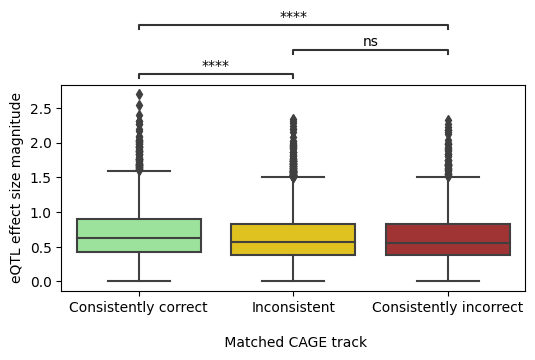

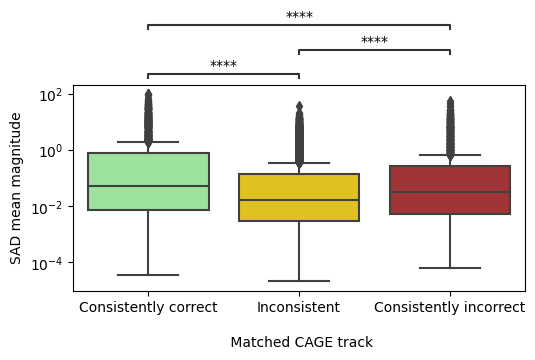

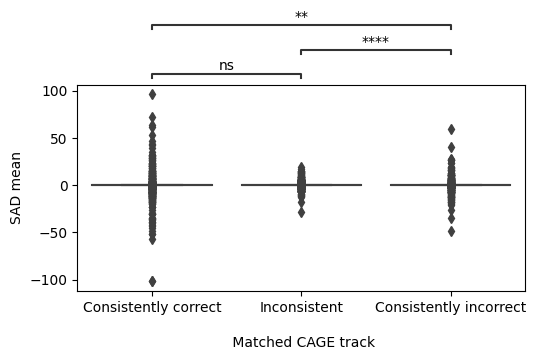

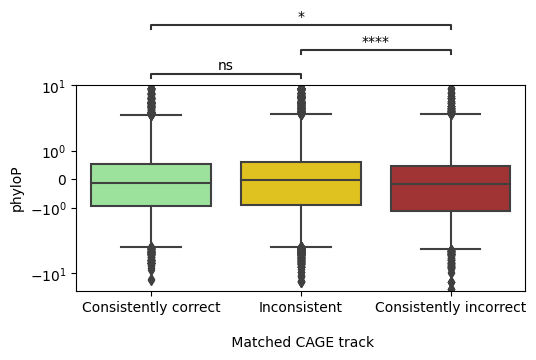

In [23]:
# Plots with significance for combined tissues df (pos set only)
pairs=[("Consistently correct", "Consistently incorrect"), 
       ("Consistently correct", "Inconsistent"), 
       ("Consistently incorrect", "Inconsistent")]
order=["Consistently correct", "Inconsistent", "Consistently incorrect"]
colors = ['lightgreen', 'gold', 'firebrick']

x="sign agreement"
for y in ["TSS distance magnitude", "eQTL effect size magnitude", "SAD mean magnitude", "SAD mean", "phyloP"]:
    fig, ax = plt.subplots(figsize=(5.5,4))
    ax = sns.boxplot(data=all_tissue_df, x=x,  y=y, ax=ax, order=order, palette=colors)
    
    if y == "phyloP":
        plt.yscale('symlog')
    if y == "SAD mean magnitude":
        plt.yscale('log')

    annotator = Annotator(ax, pairs, data=all_tissue_df, x=x, y=y)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()

    #plt.suptitle(f"Sign agreement vs. {y} \n for {assay_name} prediction for all tissues")
    plt.xlabel(f'\n Matched {assay_name} track')
    plt.tight_layout()
    y_name = y.replace(' ', '_')
    plt.savefig(f"{save_path}/{assay_name}/all_tissues_{assay_name}_sign_good_bad_noise_{y_name}.pdf", dpi=300)

## comparing majority vote sign with replicate 1 sign

In [24]:
num_samples = 100
bootstrapped_direction_predictions = pd.DataFrame([])
distance_bins = [(0, 1000), (1000, 10_000), (10_000, 30_000), (30_000, np.inf)]
   
for tissue in tlist_sorted_pos:
    df = df_results_eqtls[tissue]["pos"]
    num_rows = df.shape[0]
    
    for bin_start, bin_end in distance_bins:
        bin_inds = df[(df["TSS distance magnitude"] >= bin_start) & (df["TSS distance magnitude"] < bin_end)].index.values
        
        for rep in range(num_samples):
        
            # create set of bootstrap data for current bin and current rep
            df_sampled = df.loc[bin_inds].sample(frac=1, replace=True)

            # evaluate on ensemble majority vote
            direction_labels = (df_sampled["eQTL direction"] > 0).values
            acc = accuracy_score(direction_labels, df_sampled["SAD sign majority vote"] > 0)
            bootstrapped_direction_predictions = bootstrapped_direction_predictions.append(
                {"Tissue": tissue,
                 "Model": "ensemble majority vote",
                 "Bin": f"{bin_start}-{bin_end}",
                 "Accuracy": acc,
                 "Sample": rep},
                ignore_index=True)

            # evaluate on replicate 1
            direction_labels = (df_sampled["eQTL direction"] > 0).values
            acc = accuracy_score(direction_labels, df_sampled["SAD sign replicate 1"] > 0)
            bootstrapped_direction_predictions = bootstrapped_direction_predictions.append(
                {"Tissue": tissue,
                 "Model": "replicate 1",
                 "Bin": f"{bin_start}-{bin_end}",
                 "Accuracy": acc,
                 "Sample": rep},
                ignore_index=True)
            

/clusterfs/nilah/ayesha/envs/plotting_py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


<Figure size 800x600 with 0 Axes>

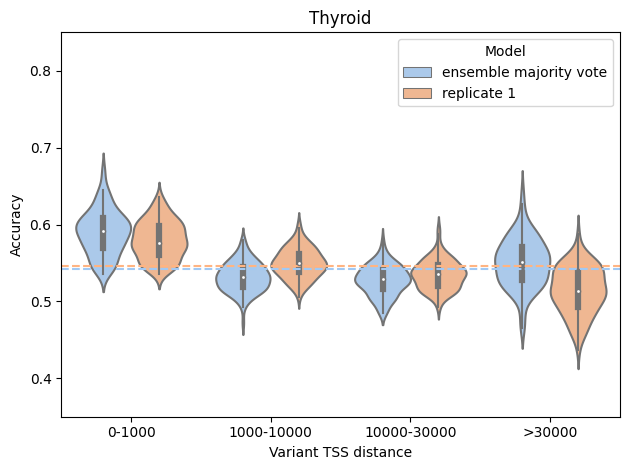

<Figure size 800x600 with 0 Axes>

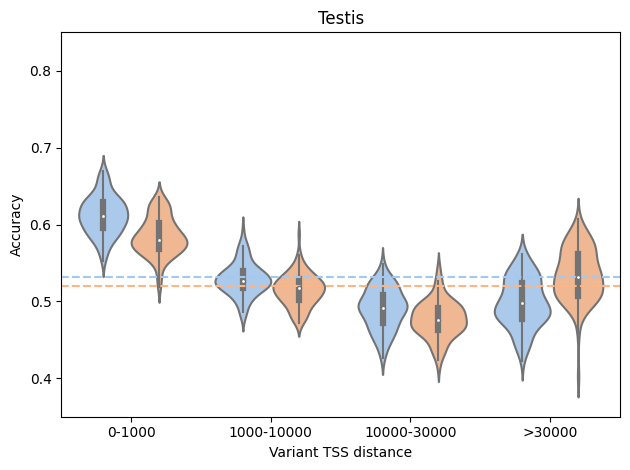

<Figure size 800x600 with 0 Axes>

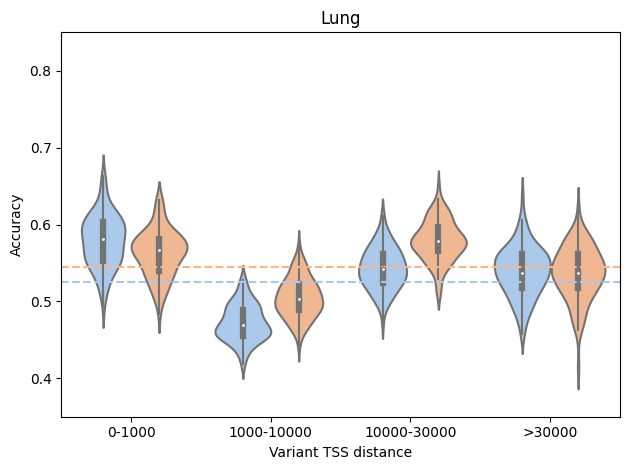

<Figure size 800x600 with 0 Axes>

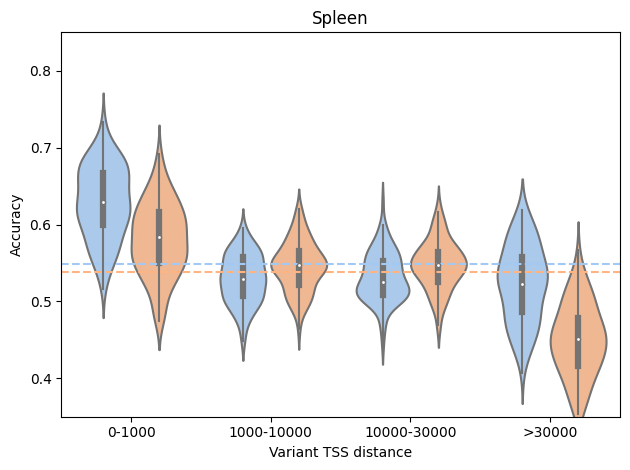

<Figure size 800x600 with 0 Axes>

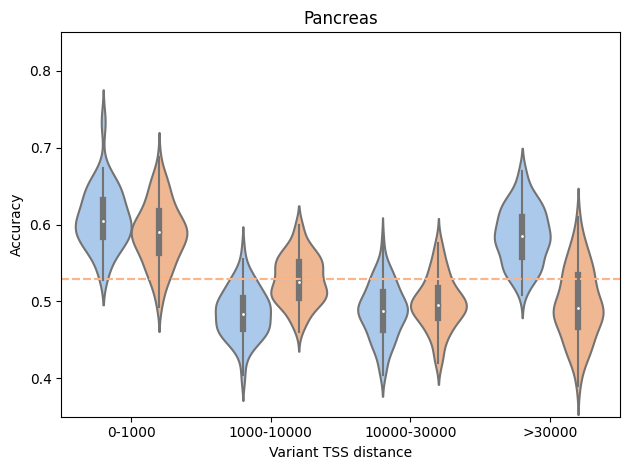

<Figure size 800x600 with 0 Axes>

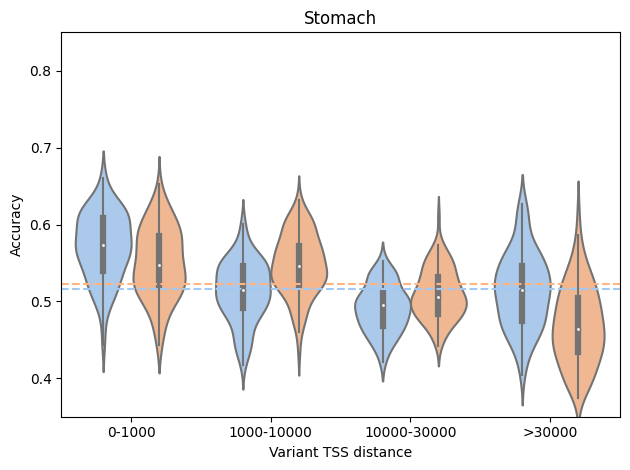

<Figure size 800x600 with 0 Axes>

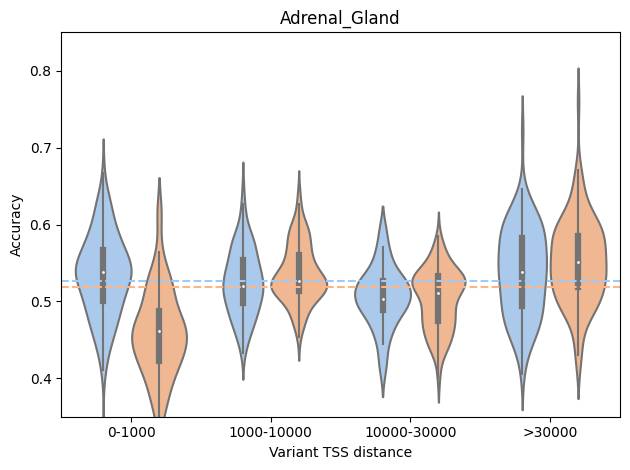

<Figure size 800x600 with 0 Axes>

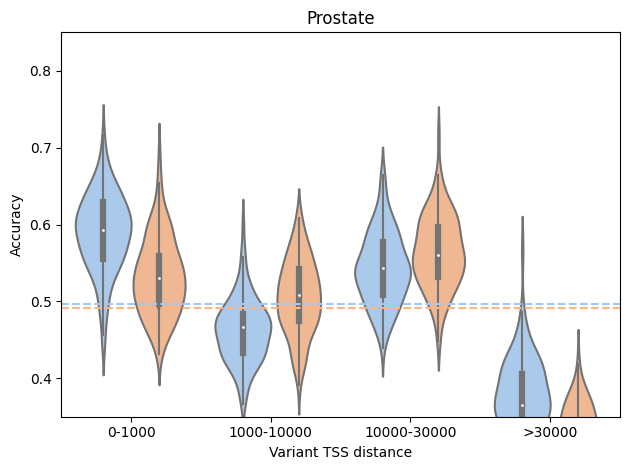

<Figure size 800x600 with 0 Axes>

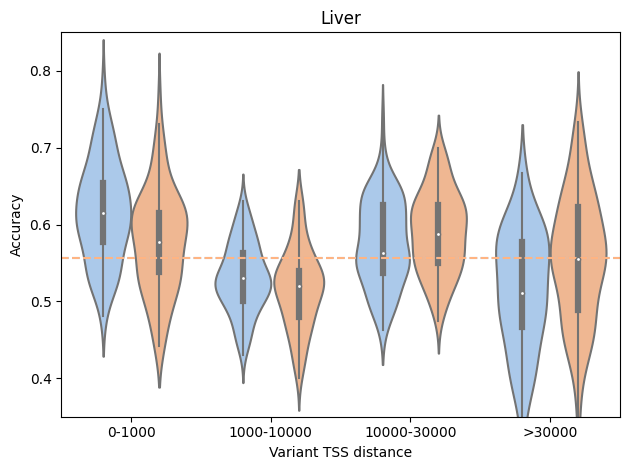

<Figure size 800x600 with 0 Axes>

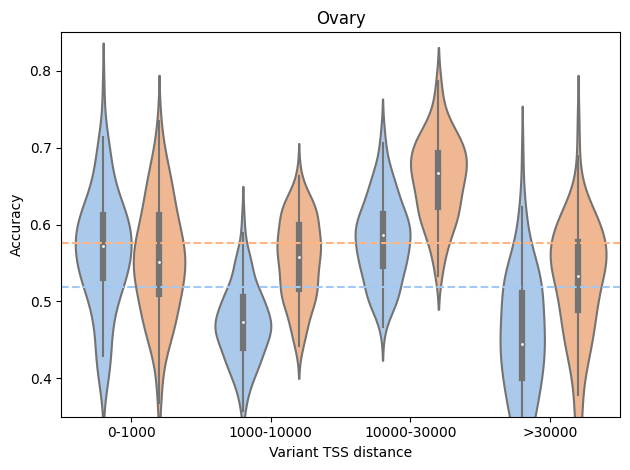

<Figure size 800x600 with 0 Axes>

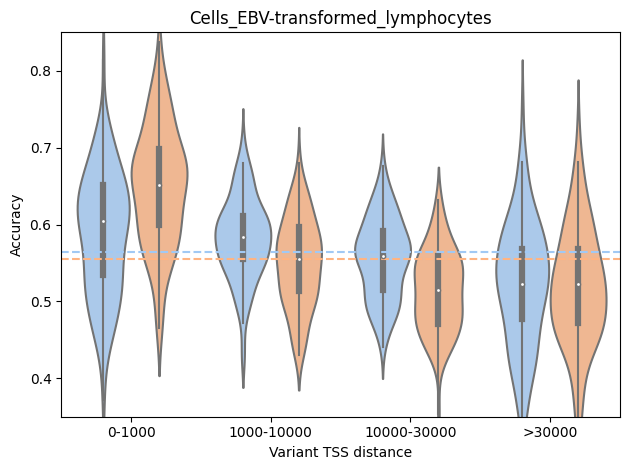

<Figure size 800x600 with 0 Axes>

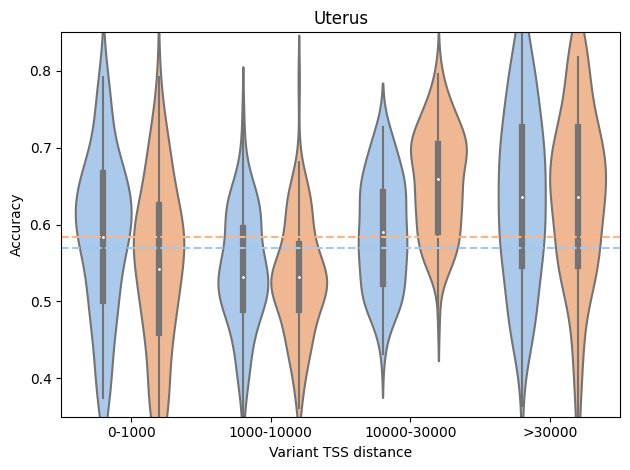

<Figure size 800x600 with 0 Axes>

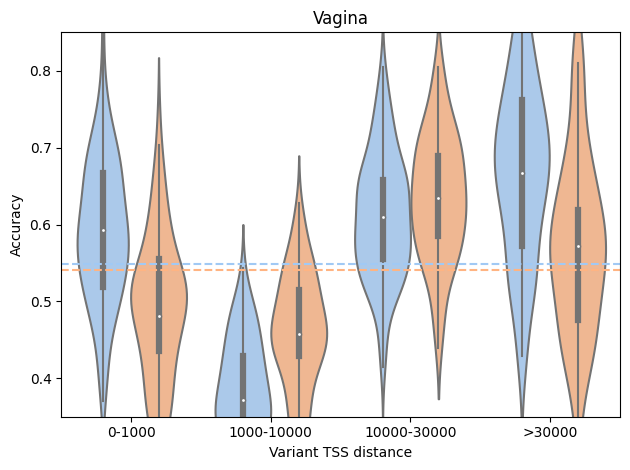

In [25]:
# violin plots using bootstrapped data

sns.set_palette('pastel')

ensemble_accs, rep1_accs = [], []

for tissue in tlist_sorted_pos:
    df = df_results_eqtls[tissue]["pos"]
    num_rows = df.shape[0]

    plt.figure(figsize=(8,6))
    
    # first plot a dashed line at the accuracies calculated for majority vote and for replicate 1
    maj_vote_acc = accuracy_score(df["eQTL direction"]>0, df['SAD sign majority vote']>0)
    ensemble_accs.append(maj_vote_acc)
    rep_1_acc = accuracy_score(df["eQTL direction"]>0, df['SAD sign replicate 1']>0)
    rep1_accs.append(rep_1_acc)

    fig, ax = plt.subplots()
    sns.violinplot(data=bootstrapped_direction_predictions[(bootstrapped_direction_predictions["Tissue"] == tissue)],
                   x="Bin", y="Accuracy", hue="Model")

    plt.ylim(0.35, 0.85)
    plt.xlim(-0.5, 3.5)
    plt.plot([-0.5, 3.5], [maj_vote_acc, maj_vote_acc], linestyle="--")
    plt.plot([-0.5, 3.5], [rep_1_acc, rep_1_acc], linestyle="--")
    
    
    plt.xticks(np.arange(4), ["0-1000", '1000-10000', '10000-30000', '>30000'])
    plt.xlabel("Variant TSS distance")
    #plt.title(f"{assay_name} sign prediction accuracy\nfor finemapped GTEx {tissue} eQTLs")
    #plt.title(f"{tissue}, {assay_name}")
    plt.title(f"{tissue}")
    plt.tight_layout()
    if tissue != "Thyroid":
        plt.legend('',frameon=False)
        #ax.get_legend().remove()
    
    plt.savefig(f'{save_path}/{assay_name}/sign_accuracy_TSS_bins_{assay_name}_{tissue}.pdf')

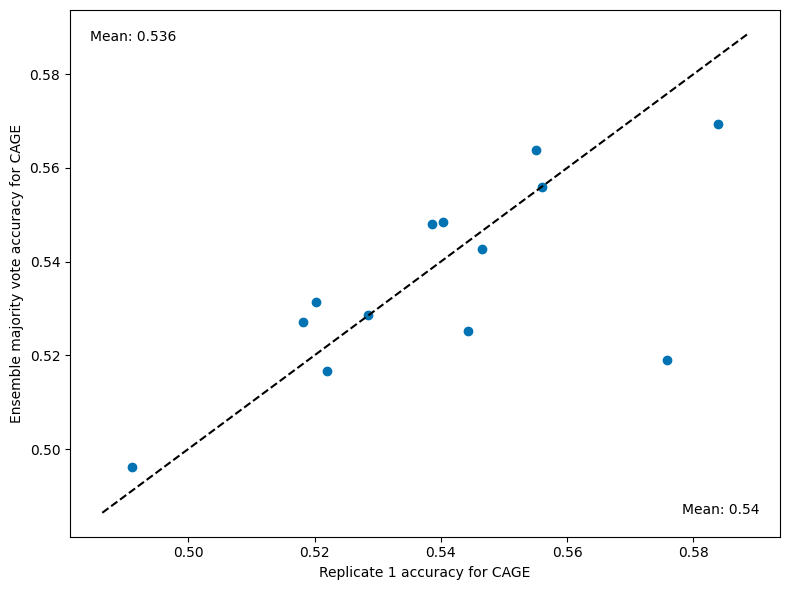

In [26]:
# scatterplot of majority vote vs. single replicate accuracy

labels = list(tlist_sorted_pos).copy()
labels[6] = "Adrenal Gland"
labels[10] = "Cells \n (EBV-transformed lymphocytes)"

sns.set_palette('colorblind')

fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(rep1_accs, ensemble_accs, )
xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, color='black', linestyle="--")

ax.annotate(f'Mean: {np.mean(rep1_accs).round(3)}',
            xy=(1, 0), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
ax.annotate(f'Mean: {np.mean(ensemble_accs).round(3)}',
            xy=(0, 1), xycoords='axes fraction',
            xytext=(20, -20), textcoords='offset pixels',
            horizontalalignment='left',
            verticalalignment='top')

plt.xlabel(f"Replicate 1 accuracy for {assay_name}")
plt.ylabel(f"Ensemble majority vote accuracy for {assay_name}")
plt.tight_layout()
plt.savefig(f'{save_path}/{assay_name}/sign_accuracy_{assay_name}_all_tissues.pdf')